<a href="https://colab.research.google.com/github/JaquesZanon/JOB/blob/main/segmenta%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
### **Martins - Segmentação de Representantes**
**Autor:** `Jaques Zanon`

**e-mail:** `jaques.zanon@gmail.com`

![An image](https://logodownload.org/wp-content/uploads/2015/04/whatsapp-logo-6.png) `(11) 97251 6634`

---

In [1]:
!pip install kneed
!pip install feature_engine
!pip install factor_analyzer
!pip install sklearn-som

  Using cached kneed-0.7.0-py2.py3-none-any.whl (9.4 kB)
  Using cached feature_engine-1.1.0-py2.py3-none-any.whl (176 kB)
  Using cached statsmodels-0.12.2-cp37-cp37m-manylinux1_x86_64.whl (9.5 MB)
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from kneed import KneeLocator
#from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
#from yellowbrick.cluster import KElbowVisualizer
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
#from sklearn.cluster import DBSCAN
#from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
#from scipy.cluster import hierarchy
from sklearn.decomposition import FactorAnalysis
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo
from factor_analyzer import (ConfirmatoryFactorAnalyzer,
                              ModelSpecificationParser)
from sklearn_som.som import SOM
from io import StringIO

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#df = pd.read_csv(StringIO(mystr), header=None, sep='|')
df = pd.read_csv('/content/drive/MyDrive/JOB-Martins/segmento.txt', sep='|')
df = df.dropna()

In [5]:
df.head()

,DtMovimento,NrPedido,IdClienteVenda,IdProduto,QtdeVendida,VlVendaLiquido,VlVendaBruto,VlTotalBruto,VlTotalLiquido,VlImpostos,CdCategoria,DsCategoria,CdSubCategoria,DsSubCategoria,IdRepComercial,DtCadastro,DsTipoPessoaRepresentante,DsTipoRepresentante,DsTerritorioVendas,DtCadastroRCA,DtSubstituicaoRepresentante,Vocaçao_dos_Municipios
0,2021-05-24,2974700.0,4391039.0,193931.0,1.0,74.10,78.41,78.41,74.10,13.96,71.0,SABAO/DETERGENTE PARA ROUPA,1.0,DETERGENTE EM PO,1171850.0,2016-12-08,PESSOA FÍSICA,VAREJO ALIMENTAR,BA_ITAPETINGA3_VAR_ATC,2016-12-08,2017-05-11,Núcleos Regionais
1,2021-05-24,2974700.0,4391039.0,216241.0,1.0,116.29,128.50,128.50,116.29,21.92,71.0,SABAO/DETERGENTE PARA ROUPA,1.0,DETERGENTE EM PO,1171850.0,2016-12-08,PESSOA FÍSICA,VAREJO ALIMENTAR,BA_ITAPETINGA3_VAR_ATC,2016-12-08,2017-05-11,Núcleos Regionais
2,2021-05-24,2993905.0,4542353.0,194950.0,3.0,25.99,26.93,80.79,77.97,19.92,14.0,SANDALIA,22.0,CASUAL,1241883.0,2020-02-18,PESSOA FÍSICA,VAREJO ALIMENTAR,BA_SALVADOR60_FAR_CAT,2020-02-18,2020-02-18,Metrópoles Desenvolvidas
3,2021-05-25,3002010.0,428799.0,215740.0,3.0,25.03,27.36,82.08,75.09,19.20,14.0,SANDALIA,22.0,CASUAL,1075456.0,2007-06-20,PESSOA FÍSICA,VAREJO ALIMENTAR,BA_SALVADOR19_VAR_ATC,2007-06-20,2010-07-16,Metrópoles Desenvolvidas
4,2021-05-26,3040084.0,6125928.0,209706.0,2.0,100.10,107.63,215.26,200.20,51.21,15.0,UTILIDADES DOMESTICAS,2.0,ESCADA DOMESTICA,1234508.0,2019-11-22,PESSOA FÍSICA,MARTCON,CE_FORTALEZA31_MAT_CAT,2019-11-22,2019-11-22,Metrópoles Desenvolvidas


In [6]:
#df = pd.read_csv("/content/drive/MyDrive/JOB-Martins/segmentacao.csv",parse_dates=True)
#df = df[df['DtCadastroRCA'].notna()]
#df.head()

In [7]:
df["DsTerritorioVendas"] = df["DsTerritorioVendas"].str.split("_", n = 1, expand = True).iloc[:,0].copy()

In [8]:
df["DsTerritorioVendas"]

0          BA
1          BA
2          BA
3          BA
4          CE
           ..
6615545    MG
6615546    TO
6615547    MG
6615548    PR
6615549    MG
Name: DsTerritorioVendas, Length: 6615550, dtype: object

### Para gerar a codificação de estados.



In [9]:
mapping = {'DF': 1, 
           'GO': 1,
           'MS': 1,
           'MT': 1, 
           'AC': 2,
           'AM': 2,
           'AP': 2, 
           'PA': 2,
           'RO': 2,
           'RR': 2, 
           'TO': 2,
           'MA': 3,
           'PI': 3, 
           'CE': 3,
           'RN': 3,
           'PB': 3, 
           'PE': 3,
           'AL': 3,
           'SE': 4, 
           'BA': 4,
           'PR': 5,
           'SC': 5, 
           'RS': 5,
           'ES': 6,
           'RJ': 6,
           'MG': 7,
           'SP': 8}

In [10]:
df = df.replace({'DsTerritorioVendas': mapping})
df = df[df['DsTerritorioVendas'].astype(str).str.isdigit()]

### Para gerar a codificação da vocação de municípios.

In [11]:
mapping = {'São Paulo': 1, 
           'Rio de Janeiro': 1,
           'Metrópoles Desenvolvidas': 1,
           'Centros Urbanos Consolidados': 2, 
           'Centros Urbanos Secundários': 2,
           'Pólos Industriais': 2,
           'Núcleos Regionais': 2,
           'Pólos Turísticos': 2,
           'Pólos de Agroindústria': 3,
           'Rural Desenvolvido': 3,
           'Movimento Iminente' : 3,
           'Núcleos Agropecuários': 4,
           'Em Busca de Oportunidades': 4,
           'Carentes de Recursos': 4}
df = df.replace({'Vocaçao_dos_Municipios': mapping})

# Calculando variaveis auxiliares

In [12]:
# Tempo_Expo
df.DtCadastroRCA = pd.to_datetime(df.DtCadastroRCA).copy()
df.DtMovimento = pd.to_datetime(df.DtMovimento).copy()


In [13]:
(df['DtMovimento'] - df['DtCadastroRCA']).dt.days/30.5

0           53.377049
1           53.377049
2           15.114754
3          166.819672
4           18.065574
              ...    
6615545    134.918033
6615546    157.737705
6615547      8.786885
6615548    186.786885
6615549     16.393443
Length: 6493405, dtype: float64

### Calculando tempo de explosição

In [14]:
df['Tempo_Expo'] = (df['DtMovimento'] - df['DtCadastroRCA']).dt.days/30.5
#df.assign(Tempo_expo = pd.to_numeric(df.DtMovimento  - df.DtCadastroRCA)).copy()
df.Tempo_Expo[df.Tempo_Expo>12]=12
df.Tempo_Expo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0          12.000000
1          12.000000
2          12.000000
3          12.000000
4          12.000000
             ...    
6615545    12.000000
6615546    12.000000
6615547     8.786885
6615548    12.000000
6615549    12.000000
Name: Tempo_Expo, Length: 6493405, dtype: float64

In [15]:
#Total_VLRecLiq_Reg 
Total_VLRecLiq_Reg = df.groupby(['DsTerritorioVendas'])[['VlVendaLiquido']].agg('sum')

In [16]:
mapping = {'VAREJO ALIMENTAR                        ': 4, 
           'MARTCON                                 ': 3,
           'FARMA NACIONAL                          ': 2,
           'INFORMATICA                             ': 1, 
           'ELETRO                                  ': 1,
           'VETERINARIO                             ': 3
           }

In [17]:
df = df.replace({'DsTipoRepresentante': mapping})

In [18]:
#Total_VLRecLiq_TipoRepr 
Total_VLRecLiq_TipoRepr = df.groupby(['DsTipoRepresentante'])[['VlVendaLiquido']].agg('sum')

In [19]:
#Média_QteClientes_TipoRepr
Media_QteClientes_TipoRepr = df.groupby(['DsTipoRepresentante'])[['IdClienteVenda']].nunique()
#df.groupby(['DsTipoNegocioRepresentanteComercial'])[['IdClienteEntrega']].count()
#df.groupby(['DsTipoNegocioRepresentanteComercial'])[['IdRepComercial']].count()
Media_QteClientes_TipoRepr



,IdClienteVenda
DsTipoRepresentante,
1,3494
2,1984
3,10432
4,74767


In [20]:
#Média_QteProduto_TipoRepr
Media_QteProduto_TipoRepr = df.groupby(['DsTipoRepresentante','NrPedido'])[['QtdeVendida']].mean().groupby(['DsTipoRepresentante'])[['QtdeVendida']].mean()
Media_QteProduto_TipoRepr

,QtdeVendida
DsTipoRepresentante,
1,8.663001
2,21.004208
3,6.911532
4,16.376437


In [21]:
#Média_QteCategoria_TipoRepr
Media_QteCategoria_TipoRepr = df.groupby(['DsTipoRepresentante'])[['CdCategoria']].nunique()
Media_QteCategoria_TipoRepr

,CdCategoria
DsTipoRepresentante,
1,78
2,75
3,78
4,80


In [22]:
#Media_QtePedidos_TipoRepr
Media_QtePedidos_TipoRepr = df.groupby(['DsTipoRepresentante','Tempo_Expo'])[['NrPedido']].nunique().groupby(['DsTipoRepresentante'])[['NrPedido']].mean()
Media_QtePedidos_TipoRepr

,NrPedido
DsTipoRepresentante,
1,135.188073
2,61.885714
3,316.909449
4,2528.527344


In [23]:
#df.DsCategoria.unique()

### Variaveis segmentadoras


In [24]:
#V1 Valor da Receita Líquida do Vendedor pelo período de exposição:
V1 = df.groupby(['IdRepComercial'])[['VlVendaLiquido']].sum().loc[:,'VlVendaLiquido']/df.groupby(['IdRepComercial'])[['Tempo_Expo']].mean().loc[:,'Tempo_Expo']
V1 = pd.DataFrame(V1).reset_index()
V1

,IdRepComercial,0
0,1051912.0,31537.900000
1,1052190.0,33838.601667
2,1053746.0,12131.832500
3,1053821.0,14038.576667
4,1054692.0,210.893333
...,...,...
2036,1278808.0,80439.739222
2037,1278809.0,22288.091652
2038,1278811.0,8233.909075
2039,1278812.0,11201.920689


In [25]:
#df[(df.CdEstadoTerritorioVendas == 2) & (df.CdEstadoTerritorioVendas == 1)]
#df["A"][(df["B"] > 50) & (df["C"] == 900)]

In [26]:
#V2 = Importância da receita líquida do Vendedor na região que ele pertence:
rec_reg=df.groupby(['DsTerritorioVendas'])[['VlVendaLiquido']].sum().loc[:,'VlVendaLiquido']
V2 = pd.DataFrame(df.groupby(['DsTerritorioVendas','IdRepComercial'])[['VlVendaLiquido']].sum().loc[:,"VlVendaLiquido"]/rec_reg.iloc[0]).reset_index().groupby(['IdRepComercial'])[['VlVendaLiquido']].mean()
V2 = pd.DataFrame(V2).reset_index()
V2

,IdRepComercial,VlVendaLiquido
0,1051912.0,0.008200
1,1052190.0,0.008798
2,1053746.0,0.003154
3,1053821.0,0.003650
4,1054692.0,0.000055
...,...,...
2036,1278808.0,0.010925
2037,1278809.0,0.003041
2038,1278811.0,0.000930
2039,1278812.0,0.001145


In [27]:
#V3 Importância da receita líquida do Vendedor categoria Tipo de Representante (Negócio)
rec_area_negocio=df.groupby(['DsTipoRepresentante'])[['VlVendaLiquido']].sum().loc[:,'VlVendaLiquido']
V3 = pd.DataFrame(df[df.DsTipoRepresentante == 1].groupby(['IdRepComercial'])[['VlVendaLiquido']].sum().loc[:,"VlVendaLiquido"]/rec_area_negocio.iloc[0]).append([
pd.DataFrame(df[df.DsTipoRepresentante == 2].groupby(['IdRepComercial'])[['VlVendaLiquido']].sum().loc[:,"VlVendaLiquido"]/rec_area_negocio.iloc[1]),
pd.DataFrame(df[df.DsTipoRepresentante == 3].groupby(['IdRepComercial'])[['VlVendaLiquido']].sum().loc[:,"VlVendaLiquido"]/rec_area_negocio.iloc[2]),
pd.DataFrame(df[df.DsTipoRepresentante == 4].groupby(['IdRepComercial'])[['VlVendaLiquido']].sum().loc[:,'VlVendaLiquido']/rec_area_negocio.iloc[3])]).reset_index()
V3 = V3*100
V3 

,IdRepComercial,VlVendaLiquido
0,106900700.0,0.801952
1,107167200.0,0.124029
2,107365000.0,0.032864
3,108541000.0,1.448659
4,108543100.0,1.684513
...,...,...
2036,127880700.0,0.043880
2037,127880800.0,0.215401
2038,127880900.0,0.059950
2039,127881100.0,0.018344


In [28]:
# V4 Vocaçao_dos_Municipios
rec_vocacao=df.groupby(['Vocaçao_dos_Municipios'])[['VlVendaLiquido']].sum().loc[:,'VlVendaLiquido']
V4 = pd.DataFrame(df[df.Vocaçao_dos_Municipios == 1].groupby(['IdRepComercial'])[['VlVendaLiquido']].sum().loc[:,"VlVendaLiquido"]/rec_vocacao.iloc[0]).append([
pd.DataFrame(df[df.Vocaçao_dos_Municipios == 2].groupby(['IdRepComercial'])[['VlVendaLiquido']].sum().loc[:,"VlVendaLiquido"]/rec_vocacao.iloc[1]),
pd.DataFrame(df[df.Vocaçao_dos_Municipios == 3].groupby(['IdRepComercial'])[['VlVendaLiquido']].sum().loc[:,"VlVendaLiquido"]/rec_vocacao.iloc[2]),
pd.DataFrame(df[df.Vocaçao_dos_Municipios == 4].groupby(['IdRepComercial'])[['VlVendaLiquido']].sum().loc[:,'VlVendaLiquido']/rec_vocacao.iloc[3])]).reset_index()
V4 = V4.groupby(['IdRepComercial'])[['VlVendaLiquido']].mean()
V4 = V4*100
V4 = pd.DataFrame(V4).reset_index()
V4

,IdRepComercial,VlVendaLiquido
0,1051912.0,0.281549
1,1052190.0,1.767720
2,1053746.0,0.546954
3,1053821.0,0.125327
4,1054692.0,0.002109
...,...,...
2036,1278808.0,0.375094
2037,1278809.0,0.104396
2038,1278811.0,0.161317
2039,1278812.0,0.039330


In [29]:
#V5 Quantidade de clientes atendidos pelo vendedor em relação a sua categoria Tipo de Representante 
#Média_QteClientes_TipoRepr
V5 = pd.DataFrame(df[df.DsTipoRepresentante == 1].groupby(['IdRepComercial'])[['IdClienteVenda']].nunique().loc[:,"IdClienteVenda"]/Media_QteClientes_TipoRepr.iloc[0,0]).append([
pd.DataFrame(df[df.DsTipoRepresentante == 2].groupby(['IdRepComercial'])[['IdClienteVenda']].nunique().loc[:,"IdClienteVenda"]/Media_QteClientes_TipoRepr.iloc[1,0]),
pd.DataFrame(df[df.DsTipoRepresentante == 3].groupby(['IdRepComercial'])[['IdClienteVenda']].nunique().loc[:,"IdClienteVenda"]/Media_QteClientes_TipoRepr.iloc[2,0]),
pd.DataFrame(df[df.DsTipoRepresentante == 4].groupby(['IdRepComercial'])[['IdClienteVenda']].nunique().loc[:,"IdClienteVenda"]/Media_QteClientes_TipoRepr.iloc[3,0])]).reset_index()
V5

,IdRepComercial,IdClienteVenda
0,1069007.0,0.013165
1,1071672.0,0.004579
2,1073650.0,0.000572
3,1085410.0,0.012021
4,1085431.0,0.013452
...,...,...
2036,1278807.0,0.000308
2037,1278808.0,0.000816
2038,1278809.0,0.000508
2039,1278811.0,0.000602


In [30]:
# V6 Quantidade de itens por quantidade em relação ao Tipo de Representante
V6 = pd.DataFrame(df[df.DsTipoRepresentante == 1].groupby(['IdRepComercial'])[['QtdeVendida']].sum().loc[:,"QtdeVendida"]/Media_QteProduto_TipoRepr.iloc[0,0]).append([
pd.DataFrame(df[df.DsTipoRepresentante == 2].groupby(['IdRepComercial'])[['QtdeVendida']].sum().loc[:,"QtdeVendida"]/Media_QteProduto_TipoRepr.iloc[1,0]),
pd.DataFrame(df[df.DsTipoRepresentante == 3].groupby(['IdRepComercial'])[['QtdeVendida']].sum().loc[:,"QtdeVendida"]/Media_QteProduto_TipoRepr.iloc[2,0]),
pd.DataFrame(df[df.DsTipoRepresentante == 4].groupby(['IdRepComercial'])[['QtdeVendida']].sum().loc[:,"QtdeVendida"]/Media_QteProduto_TipoRepr.iloc[3,0])]).reset_index()
V6 

,IdRepComercial,QtdeVendida
0,1069007.0,1817.961135
1,1071672.0,58.524750
2,1073650.0,191.042332
3,1085410.0,358.305376
4,1085431.0,466.235636
...,...,...
2036,1278807.0,1179.377420
2037,1278808.0,1745.068235
2038,1278809.0,4775.580918
2039,1278811.0,600.374795


In [31]:
#V7 Quantidade de Categorias diferentes que vendidas pelo vendedor no período, relativo a categoria de Tipo de Representante
V7 = pd.DataFrame(df[df.DsTipoRepresentante == 1].groupby(['IdRepComercial'])[['DsCategoria']].nunique().loc[:,"DsCategoria"]/Media_QteCategoria_TipoRepr.iloc[0,0]).append([
pd.DataFrame(df[df.DsTipoRepresentante == 2].groupby(['IdRepComercial'])[['DsCategoria']].nunique().loc[:,"DsCategoria"]/Media_QteCategoria_TipoRepr.iloc[1,0]),
pd.DataFrame(df[df.DsTipoRepresentante == 3].groupby(['IdRepComercial'])[['DsCategoria']].nunique().loc[:,"DsCategoria"]/Media_QteCategoria_TipoRepr.iloc[2,0]),
pd.DataFrame(df[df.DsTipoRepresentante == 4].groupby(['IdRepComercial'])[['DsCategoria']].nunique().loc[:,"DsCategoria"]/Media_QteCategoria_TipoRepr.iloc[3,0])]).reset_index()
V7 


,IdRepComercial,DsCategoria
0,1069007.0,1.243590
1,1071672.0,0.358974
2,1073650.0,0.064103
3,1085410.0,0.333333
4,1085431.0,0.525641
...,...,...
2036,1278807.0,1.412500
2037,1278808.0,1.825000
2038,1278809.0,1.587500
2039,1278811.0,0.575000


In [32]:
#V8 
V8 = pd.DataFrame((df[df.DsTipoRepresentante == 1].groupby(['IdRepComercial'])[['NrPedido']].nunique().reset_index().loc[:,"NrPedido"]/df[df.DsTipoRepresentante == 1].groupby(['IdRepComercial'])[['Tempo_Expo']].mean().reset_index().loc[:,"Tempo_Expo"])/Media_QtePedidos_TipoRepr.iloc[0,0]).append([
pd.DataFrame((df[df.DsTipoRepresentante == 2].groupby(['IdRepComercial'])[['NrPedido']].nunique().reset_index().loc[:,"NrPedido"]/df[df.DsTipoRepresentante == 2].groupby(['IdRepComercial'])[['Tempo_Expo']].mean().reset_index().loc[:,"Tempo_Expo"])/Media_QtePedidos_TipoRepr.iloc[1,0]),
pd.DataFrame((df[df.DsTipoRepresentante == 3].groupby(['IdRepComercial'])[['NrPedido']].nunique().reset_index().loc[:,"NrPedido"]/df[df.DsTipoRepresentante == 3].groupby(['IdRepComercial'])[['Tempo_Expo']].mean().reset_index().loc[:,"Tempo_Expo"])/Media_QtePedidos_TipoRepr.iloc[2,0]),
pd.DataFrame((df[df.DsTipoRepresentante == 4].groupby(['IdRepComercial'])[['NrPedido']].nunique().reset_index().loc[:,"NrPedido"]/df[df.DsTipoRepresentante == 4].groupby(['IdRepComercial'])[['Tempo_Expo']].mean().reset_index().loc[:,"Tempo_Expo"])/Media_QtePedidos_TipoRepr.iloc[3,0])])
V8 = V8.reset_index()
V8.columns = ['index', "V8"]
V8

,index,V8
0,0,0.179380
1,1,0.016643
2,2,0.007397
3,3,0.221297
4,4,0.272460
...,...,...
2036,1685,0.010573
2037,1686,0.060572
2038,1687,0.018844
2039,1688,0.013803


In [33]:
var_seg = pd.concat([V1,V2.loc[:,'VlVendaLiquido'], V3.loc[:,'VlVendaLiquido'],V4.loc[:,'VlVendaLiquido'], V5.loc[:,'IdClienteVenda'],V6.loc[:,'QtdeVendida'],V7.loc[:,'DsCategoria'],V8.loc[:,"V8"]], axis=1)
var_seg.columns = ['rep_comercial','V1','V2', 'V3', "V4", 'V5',"V6","V7","V8"]
var_seg.index = var_seg['rep_comercial']
var_seg = var_seg.drop("rep_comercial", axis=1)

In [34]:
var_seg

,V1,V2,V3,V4,V5,V6,V7,V8
rep_comercial,,,,,,,,
1051912.0,31537.900000,0.008200,0.801952,0.281549,0.013165,1817.961135,1.243590,0.179380
1052190.0,33838.601667,0.008798,0.124029,1.767720,0.004579,58.524750,0.358974,0.016643
1053746.0,12131.832500,0.003154,0.032864,0.546954,0.000572,191.042332,0.064103,0.007397
1053821.0,14038.576667,0.003650,1.448659,0.125327,0.012021,358.305376,0.333333,0.221297
1054692.0,210.893333,0.000055,1.684513,0.002109,0.013452,466.235636,0.525641,0.272460
...,...,...,...,...,...,...,...,...
1278808.0,80439.739222,0.010925,0.043880,0.375094,0.000308,1179.377420,1.412500,0.010573
1278809.0,22288.091652,0.003041,0.215401,0.104396,0.000816,1745.068235,1.825000,0.060572
1278811.0,8233.909075,0.000930,0.059950,0.161317,0.000508,4775.580918,1.587500,0.018844


In [35]:
var_seg.describe().round(5)

,V1,V2,V3,V4,V5,V6,V7,V8
count,2041.00000,2041.00000,2041.00000,2041.00000,2041.00000,2041.00000,2041.00000,2041.00000
mean,12755.75315,0.00320,0.19598,0.19316,0.00196,1726.34031,1.06083,0.03949
std,10984.51112,0.00277,0.57933,0.27152,0.00475,3294.48839,0.47892,0.10872
min,3.54833,0.00000,0.00002,0.00004,0.00001,0.12213,0.01250,0.00003
25%,4441.80250,0.00110,0.02461,0.04848,0.00037,428.72574,0.73077,0.00639
50%,10589.44854,0.00264,0.05963,0.11223,0.00067,1033.19177,1.13333,0.01368
75%,18120.49250,0.00455,0.12166,0.21110,0.00106,2041.51544,1.41250,0.02511
max,94607.88083,0.02460,11.30034,2.64027,0.06250,93899.30183,2.12500,2.62581


In [36]:
num_vars = ['V1','V2','V3', 'V4', 'V5', 'V6','V7', 'V8']
std_scaler = SklearnTransformerWrapper(transformer=StandardScaler(),
                                      variables = num_vars)

In [37]:
#std_scaler = SklearnTransformerWrapper(transformer=MinMaxScaler(),
#                                     variables = num_vars)

#### Padronizando Variáveis

In [38]:
df_aux_sc = std_scaler.fit_transform(var_seg)

In [39]:
df_aux_sc

,V1,V2,V3,V4,V5,V6,V7,V8
rep_comercial,,,,,,,,
1051912.0,1.710295,1.806787,1.046231,0.325628,2.360096,0.027817,0.381694,1.286956
1052190.0,1.919796,2.023008,-0.124231,5.800444,0.551699,-0.506368,-1.465859,-0.210207
1053746.0,-0.056814,-0.017009,-0.281631,1.303336,-0.292220,-0.466134,-2.081710,-0.295273
1053821.0,0.116813,0.162188,2.162797,-0.249870,2.118977,-0.415351,-1.519411,1.672589
1054692.0,-1.142330,-1.137348,2.570008,-0.703785,2.420376,-0.382582,-1.117769,2.143288
...,...,...,...,...,...,...,...,...
1278808.0,6.163276,2.791560,-0.262611,0.670232,-0.347989,-0.166064,0.734470,-0.266056
1278809.0,0.868011,-0.058157,0.033527,-0.326976,-0.240943,0.005686,1.595992,0.193936
1278811.0,-0.411757,-0.820891,-0.234865,-0.117287,-0.305734,0.925785,1.099964,-0.189959


### Testes para verificar a analise fatorial

Bartlett’s test of sphericity checks whether or not the observed variables intercorrelate at all using the observed correlation matrix against the identity matrix. If the test found statistically insignificant, you should not employ a factor analysis.

In [40]:
chi_square_value,p_value=calculate_bartlett_sphericity(df_aux_sc)
chi_square_value, p_value

(15787.901351260387, 0.0)

Kaiser-Meyer-Olkin (KMO) Test measures the suitability of data for factor analysis. It determines the adequacy for each observed variable and for the complete model. KMO estimates the proportion of variance among all the observed variable. Lower proportion id more suitable for factor analysis. KMO values range between 0 and 1. Value of KMO less than 0.6 is considered inadequate.

In [41]:
kmo_all,kmo_model=calculate_kmo(df_aux_sc)
kmo_model

0.6913348961297054

In [42]:
#EXPLORATORY FACTOR ANALYSIS
#fa = FactorAnalyzer(3, rotation=None)
#fa.fit(df_aux_sc)

#FactorAnalyzer(bounds=(0.005, 1), impute='median', is_corr_matrix=False,
#               method='minres', n_factors=3, rotation=None, rotation_kwargs={},
#               use_smc=True)



In [43]:
##Variacia explicada dos dados
#pd.DataFrame(fa.get_factor_variance())

In [44]:
#fa = FactorAnalyzer(3, rotation="Varimax")
#fa.fit(df_aux_sc)
#fa.get_factor_variance()
#fa.loadings_

### Análise Fatorial Confirmatória

In [45]:
model_dict = {"F1": ["V1", "V2","V3","V4"],
              "F2": ["V6", "V7", "V8"],
              "F3": ['V5']}
model_spec = ModelSpecificationParser.parse_model_specification_from_dict(df_aux_sc, model_dict)
cfa = ConfirmatoryFactorAnalyzer(model_spec, disp=True)
cfa.fit(df_aux_sc)
cfa.loadings_.round(2)


/usr/local/lib/python3.7/dist-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))


array([[1.05, 0.  , 0.  ],
       [1.05, 0.  , 0.  ],
       [0.67, 0.  , 0.  ],
       [0.96, 0.  , 0.  ],
       [0.  , 0.84, 0.  ],
       [0.  , 0.93, 0.  ],
       [0.  , 0.89, 0.  ],
       [0.  , 0.  , 0.87]])

In [46]:
# Calculo dos autovalores
sum(pd.DataFrame(cfa.loadings_.round(2)).iloc[:,0]**2)+sum(pd.DataFrame(cfa.loadings_.round(2)).iloc[:,1]**2)+sum(pd.DataFrame(cfa.loadings_.round(2)).iloc[:,2]**2)

6.695

In [47]:
def percentage(part, whole):
  return 100 * float(part)/float(whole)

percentage(sum(pd.DataFrame(cfa.loadings_.round(2)).iloc[:,2]**2),whole=6.695)

11.305451829723674

In [48]:
fact_trans = pd.DataFrame(cfa.fit_transform(df_aux_sc))
um = (fact_trans.iloc[:,0]-min(fact_trans.iloc[:,0]))/(max(fact_trans.iloc[:,0])-min(fact_trans.iloc[:,0]))
dois = (fact_trans.iloc[:,1]-min(fact_trans.iloc[:,1]))/(max(fact_trans.iloc[:,1])-min(fact_trans.iloc[:,1]))
tres = (fact_trans.iloc[:,2]-min(fact_trans.iloc[:,2]))/(max(fact_trans.iloc[:,2])-min(fact_trans.iloc[:,2]))

/usr/local/lib/python3.7/dist-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning: The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  'to converge: {}'.format(str(res.message)))


In [49]:
Indicador_Norm = pd.DataFrame(pd.concat([um,dois,tres],axis=1))

In [50]:
Indicador_Norm = np.where(Indicador_Norm < 0, 0, Indicador_Norm)
Indicador_Norm = np.where(Indicador_Norm > 1, 1, Indicador_Norm)
Indicador_Norm


array([[0.34828715, 0.16482768, 0.06830241],
       [0.53083963, 0.04635172, 0.00632595],
       [0.17983815, 0.00813478, 0.00280456],
       ...,
       [0.07547077, 0.1484759 , 0.00716415],
       [0.07827451, 0.0438289 , 0.00524416],
       [0.21553664, 0.06294068, 0.00502987]])

In [51]:
#Pesos = [0.53,0.31,0.11]
um = pd.DataFrame(Indicador_Norm[:,0]*0.53)
dois = pd.DataFrame(Indicador_Norm[:,1]*0.31)
tres = pd.DataFrame(Indicador_Norm[:,2]*0.11)
Indicador_final = pd.DataFrame(pd.concat([um,dois,tres],axis=1))
Indicador_final = Indicador_final.sum(axis=1)
Indicador_final = 100 * Indicador_final/float(max(Indicador_final))
Indicador_final

0       44.624868
1       54.387917
2       18.008424
3       23.767461
4       11.553901
          ...    
2036    66.346741
2037    25.234333
2038    15.929603
2039    10.211029
2040    24.642430
Length: 2041, dtype: float64

In [52]:
Indicador_final = pd.concat([df_aux_sc.reset_index().iloc[:,0],Indicador_final], axis=1)

In [53]:
Indicador_final.index = Indicador_final.rep_comercial
Indicador_final.head()

,rep_comercial,0
rep_comercial,,
1051912.0,1051912.0,44.624868
1052190.0,1052190.0,54.387917
1053746.0,1053746.0,18.008424
1053821.0,1053821.0,23.767461
1054692.0,1054692.0,11.553901


In [122]:
df_aux_2 =df[['DsTipoRepresentante','IdRepComercial']]
df_aux_2.columns = ['DsTipoRepresentante','rep_comercial']
df_aux_2.index = df_aux_2['rep_comercial']
df_aux_2 = pd.merge(Indicador_final, df_aux_2, left_index=True, right_index=True, how="inner")
df_aux_2.columns = ['rep_comercial_x','um','DsTipoRepresentante','rep_comercial_y']
df_aux_2 = df_aux_2[['um','DsTipoRepresentante','rep_comercial_x']]
df_aux_2 = df_aux_2.groupby(['DsTipoRepresentante','rep_comercial_x'])[['um']].mean().unstack(level=0,fill_value=0)

In [123]:
df_aux_2.columns = df_aux_2.columns.droplevel()
#df_aux_2.reset_index()
df_aux_2.columns

In [131]:
df_aux_2.columns=['um','dois','tres','quatro']

In [145]:
df_aux_2.sort_values(by=['um','dois','tres','quatro'],ascending=False)

,um,dois,tres,quatro,segKmeans
rep_comercial_x,,,,,
1241944.0,100.000000,0.0,0.0,0.000000,1
1241949.0,69.988953,0.0,0.0,0.000000,1
1085545.0,54.853804,0.0,0.0,0.000000,1
1241967.0,54.190543,0.0,0.0,0.000000,1
1241950.0,54.082039,0.0,0.0,0.000000,1
...,...,...,...,...,...
1214334.0,0.000000,0.0,0.0,0.625022,0
1223728.0,0.000000,0.0,0.0,0.504493,0
1215139.0,0.000000,0.0,0.0,0.466934,0


In [179]:
print((df_aux_2['um'].max()-df_aux_2['um'].min())/5)
print((df_aux_2['dois'].max()-df_aux_2['um'].min())/5)
print((df_aux_2['tres'].max()-df_aux_2['um'].min())/5)
print((df_aux_2['quatro'].max()-df_aux_2['um'].min())/5)

20.0
9.702040407594092
15.683236875815671
16.111502933215906


In [189]:
#df_aux_2.query('um <= 20 & dois <= 9.7 & tres <= 15.68 & quatro <= 16.11')
#df_aux_2.query('um > 40 & um <= 60 & dois > 19.4 & dois <= 29.1 & tres > 31.36 & tres <= 47.04 & quatro > 32.22 & quatro <=48.33 ')

,um,dois,tres,quatro,segKmeans
rep_comercial_x,,,,,


In [139]:
 #A list holds the SSE values for each k
sse = []
for k in range(1, 21):
        kmeans = KMeans(n_clusters=k,max_iter=300)
        kmeans.fit(df_aux_2)
        sse.append(kmeans.inertia_)


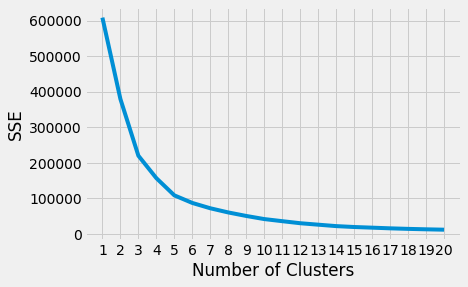

In [140]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 21), sse)
plt.xticks(range(1, 21))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

#### Esse resultado abaixo mostra o numero de grupos ótimo igual a 5.

In [141]:
kl = KneeLocator(
        range(1, 21), sse, curve="convex", direction="decreasing"
    )
kl.elbow

5

In [142]:
kmeans = KMeans(
   init="random",
   n_clusters=5,
   n_init=10,
   max_iter=400,
   random_state=42
)

In [143]:
kresultado = kmeans.fit(df_aux_2)

In [144]:
df_aux_2["segKmeans"] = kresultado.labels_

In [172]:
#df_aux_2.sort_values(by=['um','dois','tres','quatro'],ascending=False).boxplot(column =['tres'], grid=False, rot=45, fontsize=15)
#df_aux_2.sort_values(by=['um','dois','tres','quatro'],ascending=False).hist(bins=15)
df_aux_2 = df_aux_2.sort_values(by=['um','dois','tres','quatro'],ascending=False)

#### Visualizando o resultado K-means

In [173]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df_aux_2.drop(['segKmeans'],axis=1))
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, df_aux_2[['segKmeans']].reset_index().iloc[:,1]], axis = 1)
finalDf.clumns = ['principal component 1', 'principal component 2','segKmeans']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


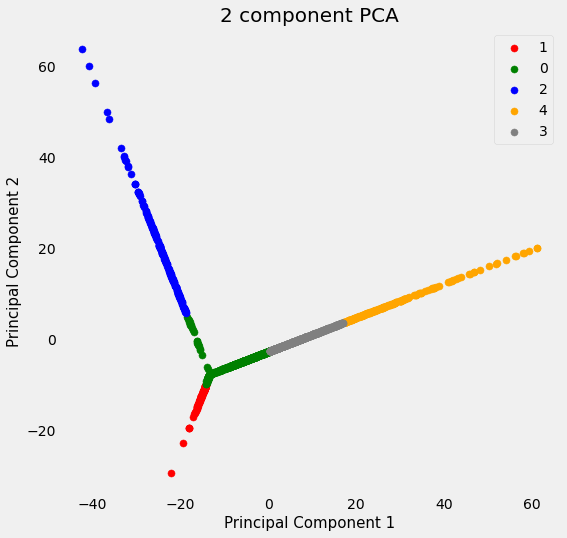

In [174]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = df_aux_2.segKmeans.unique()
colors = ['r', 'g', 'b','orange','grey']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf.segKmeans == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
pd.DataFrame(pca.components_.T * np.sqrt(pca.explained_variance_))#loadings

In [207]:
df_aux_2

,um,dois,tres,quatro,segKmeans
rep_comercial_x,,,,,
1241944.0,100.000000,0.0,0.0,0.000000,1
1241949.0,69.988953,0.0,0.0,0.000000,1
1085545.0,54.853804,0.0,0.0,0.000000,1
1241967.0,54.190543,0.0,0.0,0.000000,1
1241950.0,54.082039,0.0,0.0,0.000000,1
...,...,...,...,...,...
1214334.0,0.000000,0.0,0.0,0.625022,0
1223728.0,0.000000,0.0,0.0,0.504493,0
1215139.0,0.000000,0.0,0.0,0.466934,0


In [212]:
tabulacao = df_aux_2.reset_index().groupby('segKmeans').nunique()
tabulacao.to_csv('/content/drive/MyDrive/JOB-Martins/tabela_cunfusin.csv')

Text(0.5, -1.340000000000014, 'Features')

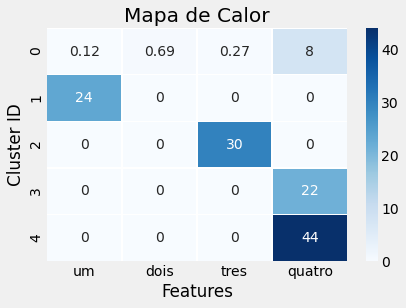

In [204]:
import matplotlib.pyplot as plt


fig, ax=plt.subplots()
sns.heatmap(tabulacao, ax=ax, annot = True,linewidths=.5,cmap="Blues");
ax.set_title("Mapa de Calor");
ax.set_ylabel("Cluster ID");
ax.set_xlabel("Features")

In [ ]:
df_rfv = df.groupby

In [213]:
df_aux_2[['segKmeans']].to_csv('/content/drive/MyDrive/JOB-Martins/resultado_segmentação.csv')